We create truth subsets for each alternative allele frequency (AAF; also known as variant allele frequency, VAF) in each mix of the 4 CEPH/Utah grandparental genomes.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import attila_utils
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150
#matplotlib.rcParams['figure.figsize'] = [7, 5]
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joint_gt_ceph as jgc
import truth_sets_aaf as tsa
from scipy import stats

## Distribution of AAF

The operations below create truth subsets for each frequency vaf, variant type (snp or indel) and sample (mix1, mix2, mix3) and also calculate the size of each subset (nvariants)

In [3]:
if True:
    nvariants = tsa.make_ts_aaf_get_nvariants()

In [4]:
nvariants.to_csv('~/projects/bsm/results/2019-04-04-truth-sets-aaf/nvariants.csv', index=False)
nvariants.head()

,region,vartype,sample,AAF,count
0,chr22,snp,mix1,2,11351
1,chr22,snp,mix1,4,15342
2,chr22,snp,mix1,6,3641
3,chr22,snp,mix1,8,18832
4,chr22,snp,mix1,10,6239


Below is the empirical distribution of AAF for various samples and variant types.

['named-figure/vaf-mix123-vaf.png', 'named-figure/vaf-mix123-vaf.pdf']

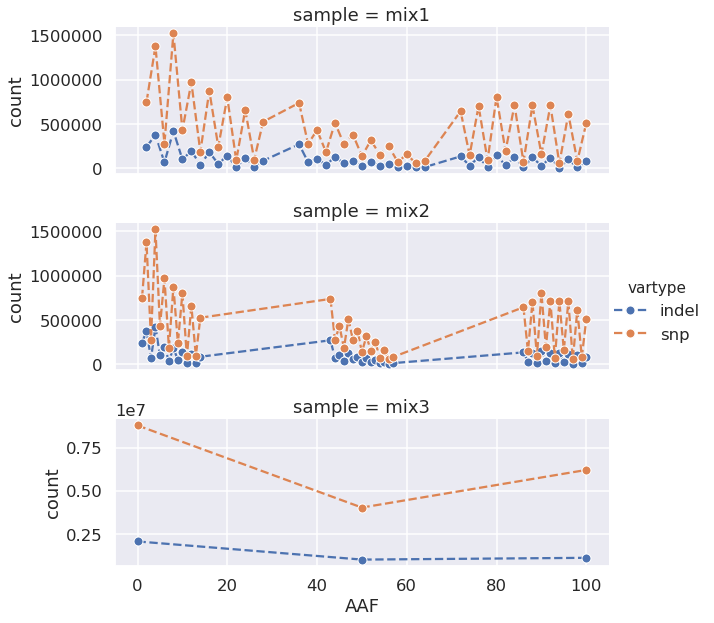

In [5]:
sns.set()
sns.set_context('talk')
def nvar_aaf_plot(region='autosomes'):
    fg = sns.FacetGrid(data=nvariants.loc[nvariants['region'] == region, :], row='sample', hue='vartype', sharey=False, aspect=3)
    fg = fg.map(plt.plot, 'AAF', 'count', marker='o', markeredgecolor='white', linestyle='dashed')
    fg = fg.add_legend()
    return(fg)

g = nvar_aaf_plot('autosomes')
attila_utils.savefig(g, 'vaf-mix123-vaf')

['named-figure/vaf-mix123-vaf-chr1_2.png',
 'named-figure/vaf-mix123-vaf-chr1_2.pdf']

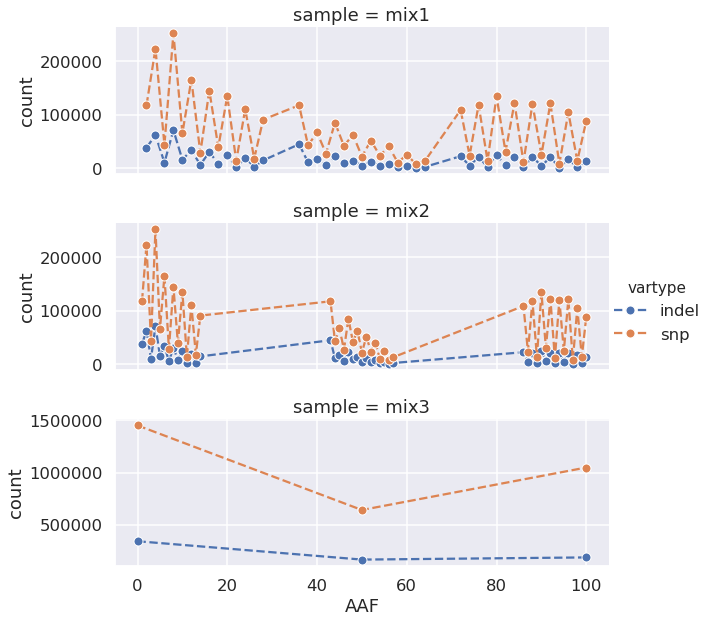

In [6]:
g = nvar_aaf_plot('chr1_2')
attila_utils.savefig(g, 'vaf-mix123-vaf-chr1_2')

['named-figure/vaf-mix123-vaf-chr22.png',
 'named-figure/vaf-mix123-vaf-chr22.pdf']

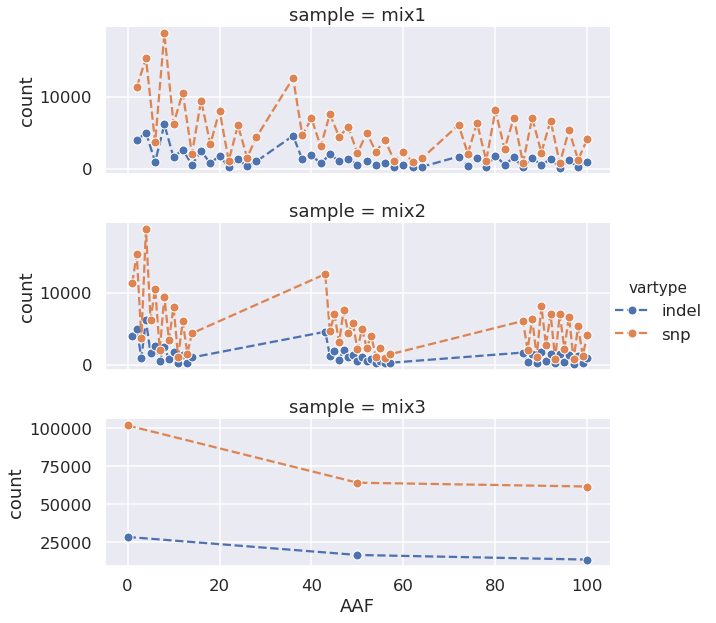

In [7]:
g = nvar_aaf_plot('chr22')
attila_utils.savefig(g, 'vaf-mix123-vaf-chr22')

Comparing the picture on all autosomes to that on chr22

['named-figure/vaf-chr22-chr1_2-autosomes.png',
 'named-figure/vaf-chr22-chr1_2-autosomes.pdf']

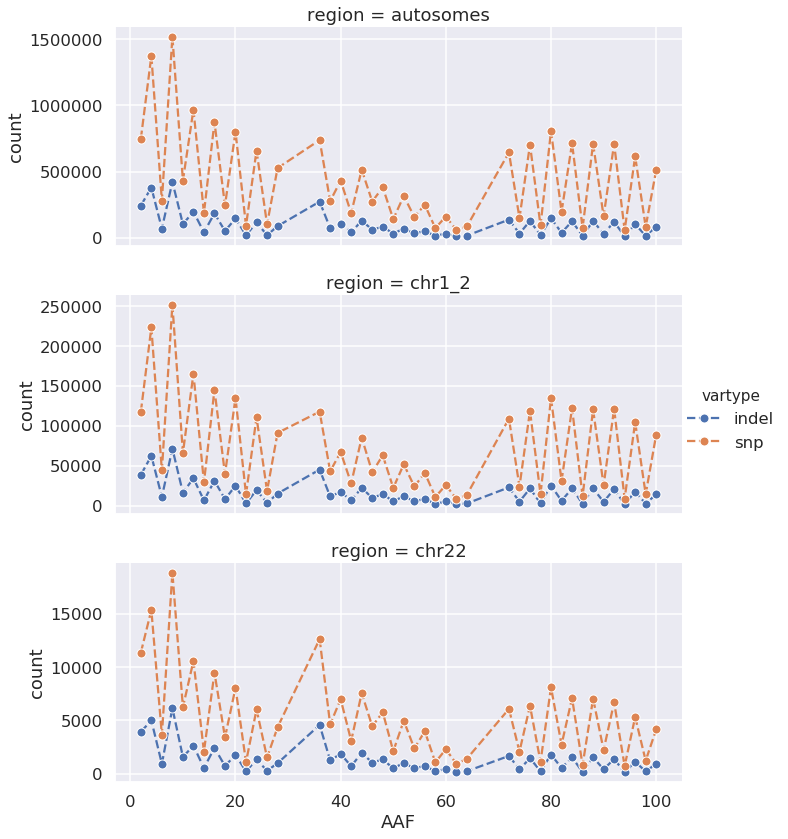

In [8]:
fg = sns.FacetGrid(data=nvariants.loc[nvariants['sample'] == 'mix1', :], row='region', hue='vartype', sharey=False, aspect=2.5, height=4)
fg = fg.map(plt.plot, 'AAF', 'count', marker='o', markeredgecolor='white', linestyle='dashed')
fg.add_legend()
attila_utils.savefig(fg, 'vaf-chr22-chr1_2-autosomes')

To calculate the total number of variants by summing the number of variants over all frequencies

In [9]:
def do_sum(mix, vartype, region):
    a = nvariants['sample'] == mix
    b = nvariants['vartype'] == vartype
    c = nvariants['region'] == region
    nvars = nvariants.loc[[y[0] and y[1] and y[2] for y in zip(a, b, c)], 'count']
    return(sum(nvars))

{r: {v: {m: do_sum(m, v, r) for m in ['mix1', 'mix2', 'mix3']} for v in ['snp', 'indel']} for r in ['chr22', 'chr1_2', 'autosomes']}

{'chr22': {'snp': {'mix1': 228141, 'mix2': 228141, 'mix3': 228141},
  'indel': {'mix1': 59056, 'mix2': 59056, 'mix3': 59056}},
 'chr1_2': {'snp': {'mix1': 3141598, 'mix2': 3141598, 'mix3': 3141598},
  'indel': {'mix1': 701310, 'mix2': 701310, 'mix3': 701310}},
 'autosomes': {'snp': {'mix1': 19062855, 'mix2': 19062855, 'mix3': 19062855},
  'indel': {'mix1': 4198980, 'mix2': 4198980, 'mix3': 4198980}}}

### Chaggai's model

We close this section with an attempt to reconstruct what Chaggai did to change the distribution of AAF in order to make it more realistic.  We call the resulting distribution a *model*.  Below we will systematically discuss and design models. 

In [10]:
x = nvariants.loc[(nvariants['region'] == 'chr22') & (nvariants['sample'] == 'mix1') & (nvariants['vartype'] == 'snp'), :]
y = x.copy()
y.loc[y['AAF'] > 28, 'count'] = 0
x.insert(0, 'model', 'mix')
y.insert(0, 'model', 'M_Chaggai')
modeled_nvar_chaggai = pd.concat([x, y])

['named-figure/vaf-mix1-M_Chaggai.png', 'named-figure/vaf-mix1-M_Chaggai.pdf']

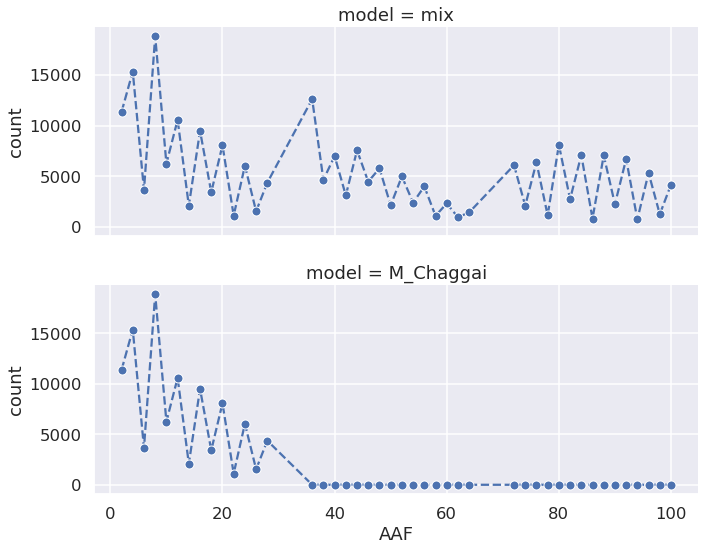

In [11]:
fg = sns.FacetGrid(data=modeled_nvar_chaggai, row='model', sharey=True, aspect=2.5, height=4)
fg = fg.map(plt.plot, 'AAF', 'count', marker='o', markeredgecolor='white', linestyle='dashed')
fg.add_legend()

attila_utils.savefig(fg, 'vaf-mix1-M_Chaggai')

## Modeling AAF distribution

### Downsampling truth subsets

We don't know the number of somatic mutations in neurons.  More precisely we don't know the average number nor how it varies across cells.  Therefore we neither know how the relationship between the number of variants and alternative allele frequency (AAF) in our multinuclear/multicellular samples for bulk sequencing.

This forces us to be hypothetical, simplifying, and allow a few distinct models that describe both the total number of somatic variants as well as dependence on AAF.

I use the following simple principles
1. the total number of somatic variants is some small fraction of that of germline variants both for SNPs/SNVs and indels
1. the number of somatic variants is a simple analytical function of AAF

#### Remarks

If the function is decreasing it means that we believe that most somatic mutations arose relatively late so that they didn't have the opportunity to spread out to larger mosaic areas.

Excluding $\{0.5\}$ means that we use the simplifying assumption that if a variant has AAF it means it can only be a germline variant for which the individual is heterozygous.  Thus any call of *somatic* variants at $\mathrm{AAF}=0.5$ will be considered false even if we allow some somatic variants at, say, $\mathrm{AAF}=0.48$.

### Modeling considerations

We will consider two aspects for building models
1. the total number of somatic variants
1. the distribution of AAF

### The total number of somatic variants

Let $Y$ denote the total number of somatic variants.  We will speculatively set $Y$ as a fixed fraction of the number of germline variants.

To deal with germline variants we make use of the length of all autosomes and of chr22, which are obtained from `/big/data/refgenome/GRCh37/hs37d5/hs37d5.fa.fai`.

In [12]:
hs37d5_len = {'autosomes': 2929051733, 'chr1_2': 249250621 + 243199373, 'chr22': 51304566}

The number for germline SNPs in an "average" human is 4.5 million based on [common knowledge](https://ghr.nlm.nih.gov/primer/genomicresearch/snp); my recent analysis shows that this is consistent with the number of germline SNPs in NA12889.  The same analysis gave more that 0.7 million indels for NA12889.

In [13]:
germ_vars = {'snp': 4e6, 'indel': 0.8e6}
germ_vars = tsa.combine_regions_germ_vars(regions=hs37d5_len, germ_vars=germ_vars)
germ_vars

,snp,indel
autosomes,4000000,800000
chr1_2,672504,134500
chr22,70063,14012


If $G$ is the number of somatic variants (SNPs or indels in chr22 or all autosomes) then let
$$
\begin{eqnarray}
Y^{(1)} &=& 10^{-2} G \\
Y^{(2)} &=& 10^{-3} G \\
Y^{(3)} &=& 10^{-4} G
\end{eqnarray}
$$


### The distribution of AAF

Let total number of somatic variants $Y\equiv Y^{(k)}$ for some fixed $k\in \{1, 2, 3\}$.  Then $Y = \sum_{i=1}^{n} y_i$, where $\{(y_i, x_i)\}_{i=1,...,n}$ is the set of $n$ point pairs $(y_i, x_i)$ of somatic variant count $y_i$ and the corresponding alternative allele frequency $x_i$.

$\{x_i\}_{i=1,...,n}$ are already given.  $Y$ will be given below.  The goal is to obtain $\{y_i\}_{i=1,...,n}$ under some simple mathematical model.  We will consider the following classes of models:
1. exponential
2. linear

## Exponential models

The following arguments support exponential models

1. the empirical distribution of AAF from Taejeong Bae et al 2018 (Science 359 (6375), 550-555) is well fitted by a decaying exponential; see the post [2019-04-24-vaf-model-taejeong]({{ site.baseurl }}{% post_url /projects/bsm/2019-04-24-vaf-model-taejeong %})
1. theoretically the distribution is exponential if the rate of cell division and rate of somatic mutation per cell cycle is constant.  This is true if cell division is symmetric.  (Is it true in case of asymmetric cell division?  Currently I don't have a definite answer.)

For these reasons we favor exponential models over linear or other classes of models.

In [14]:
vaf_emp = tsa.get_taejeongs_aaf(samples=['S316', 'S320'], scale2pct=True)
lambdas = {c: tsa.lambda_hat(vaf_emp[vaf_emp['sample'] == c]['VAF']) for c in vaf_emp['sample'].cat.categories}
pd.DataFrame(lambdas, index=['lambda_hat'])

,S316,S320,pooled
lambda_hat,0.221052,0.235704,0.224425


We create several exponential models distinguished by

1. the rate parameter $\lambda$
    * one level of $\lambda$ is $0.2\approx \hat{\lambda}$ corresponding to the empirical value from T Bae et al 2018
    * another level of $\lambda$ is $0.04$ resulting in $5\times$ slower decay of somatic variant count as a function of AAF
2. the total number of variants ($n_\mathrm{tot}$, the $y$-scale); whose levels are determined by two further parameters:
    * $\log_{10} \mathrm{s2g}$, the base 10 log of the odds of somatic : germline variants
    * the type of variants $\mathrm{vartype}$
3. the possible AAF values determined by $\mathrm{sample}\in \{\mathrm{mix1}, \mathrm{mix2}, \mathrm{mix3}\}$

Below is the set of histograms for all combinations of all levels of the above three factors:

In [15]:
expm = tsa.exp_model_df_concat(nvariants, s2gs=[-2, -3, -4], lambdas=[0.2, 0.04])
expm.to_csv('~/projects/bsm/results/2019-04-04-truth-sets-aaf/exp_model.csv', index=False)
expm.head()

,AAF,count,region,sample,vartype,s2g,ntot,lambda
0,2,2644,autosomes,mix1,indel,-2,8000,0.2
1,4,1772,autosomes,mix1,indel,-2,8000,0.2
2,6,1188,autosomes,mix1,indel,-2,8000,0.2
3,8,796,autosomes,mix1,indel,-2,8000,0.2
4,10,533,autosomes,mix1,indel,-2,8000,0.2


In [16]:
expm.tail()

,AAF,count,region,sample,vartype,s2g,ntot,lambda
1,50,0,chr22,mix3,snp,-4,7,0.20
2,100,0,chr22,mix3,snp,-4,7,0.20
0,0,6,chr22,mix3,snp,-4,7,0.04
1,50,0,chr22,mix3,snp,-4,7,0.04
2,100,0,chr22,mix3,snp,-4,7,0.04


### Exponential models at $\log_{10}\mathrm{s2g}=-3$

These are the models with 1:1000 odds of somatic : germline variants in total.

#### All autosomes

['named-figure/exp-model0.png', 'named-figure/exp-model0.pdf']

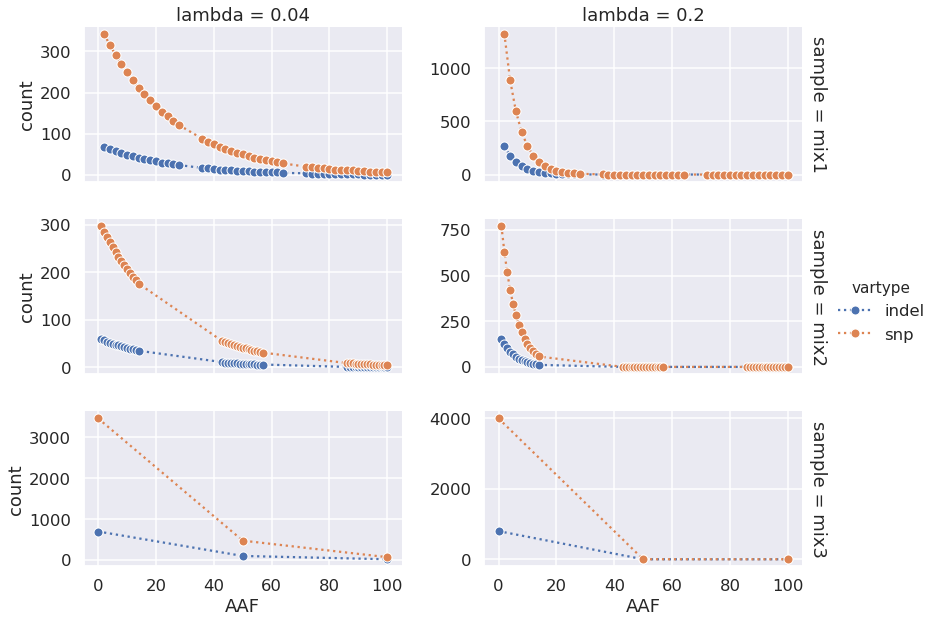

In [17]:
fg = tsa.exp_model_plot0(expm, s2g=-3, region='autosomes')
attila_utils.savefig(fg, 'exp-model0')

#### chr1_2

['named-figure/exp-model1.png', 'named-figure/exp-model1.pdf']

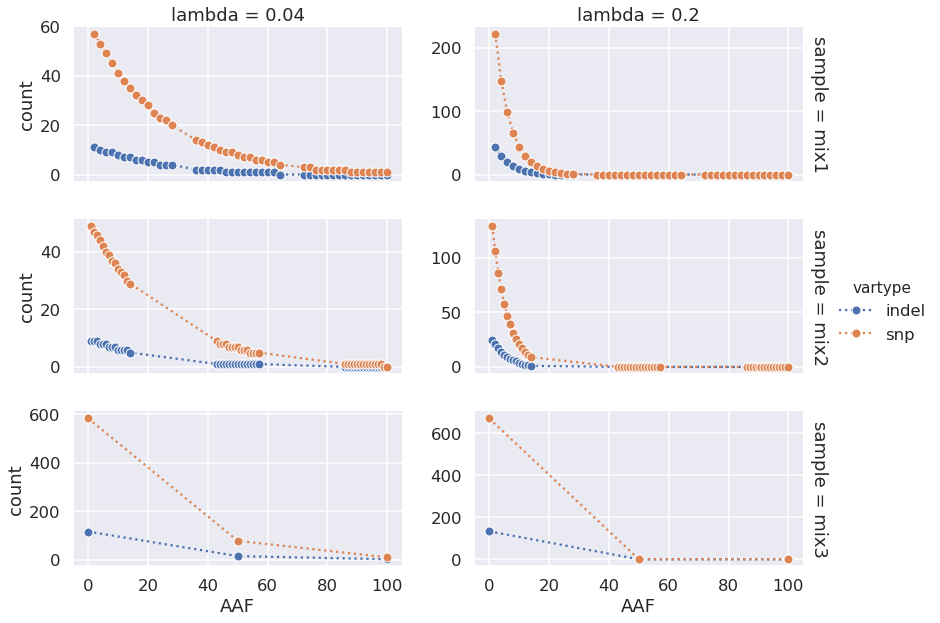

In [18]:
fg = tsa.exp_model_plot0(expm, s2g=-3, region='chr1_2')
attila_utils.savefig(fg, 'exp-model1')

Taking only chr22 (or at less negative $\log_{10}\mathrm{s2g}$) we have fewer variants and therefore the plots look steplike because rounding to integers has larger effect.

#### chr22

['named-figure/exp-model2.png', 'named-figure/exp-model2.pdf']

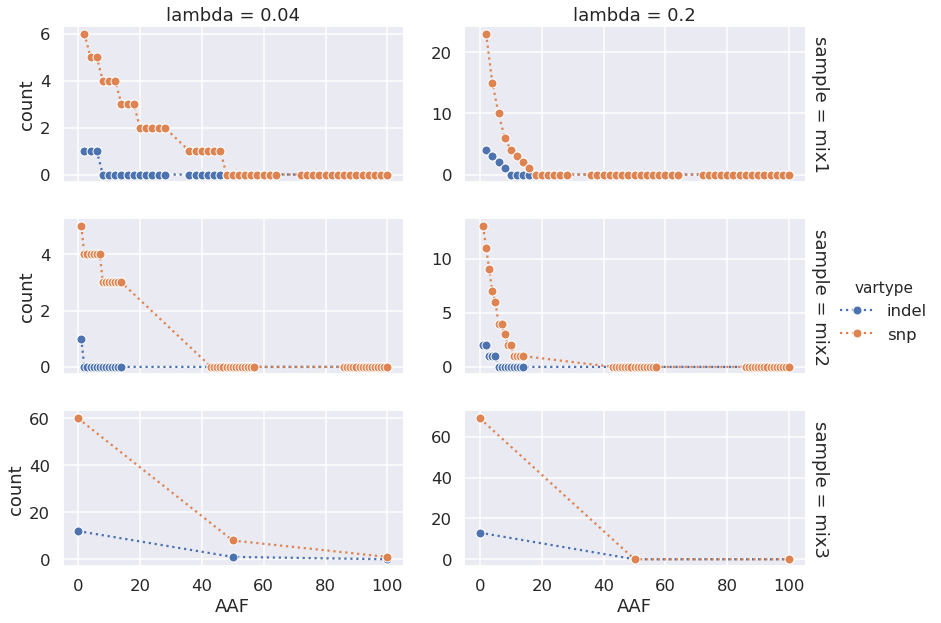

In [19]:
fg = tsa.exp_model_plot0(expm, s2g=-3, region='chr22')
attila_utils.savefig(fg, 'exp-model2')

### Other views

['named-figure/exp-model-mix3.png', 'named-figure/exp-model-mix3.pdf']

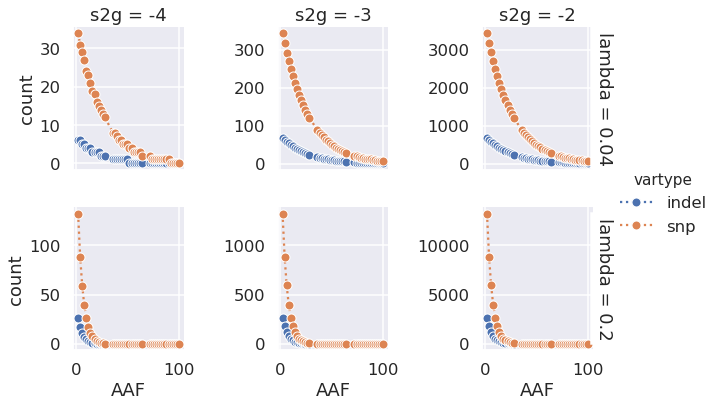

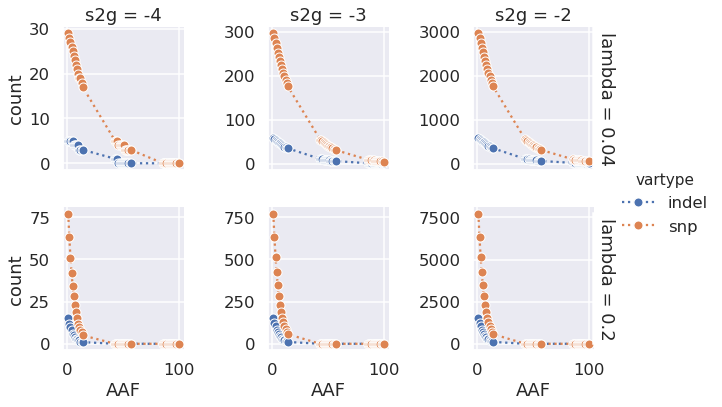

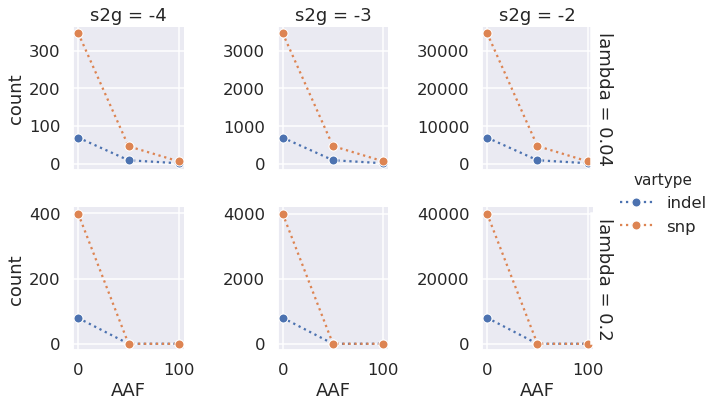

In [20]:
fg = tsa.exp_model_plot1(expm, sample='mix1', region='autosomes')
attila_utils.savefig(fg, 'exp-model-mix1')
fg = tsa.exp_model_plot1(expm, sample='mix2', region='autosomes')
attila_utils.savefig(fg, 'exp-model-mix2')
fg = tsa.exp_model_plot1(expm, sample='mix3', region='autosomes')
attila_utils.savefig(fg, 'exp-model-mix3')

## Linear models

The models of AAF distribution in this section are called *linear* but to avoid confusion they are not the same as linear regression models.  In our models the number of somatic variants is a linear function of AAF that
    
* is either constant or decreasing
* takes values on the domain $X$ such that $\mathrm{AAF} \in X \subset (0, 1) \setminus \{0.5\}$

We will name our linear models as $L_1,...$

### At a given total number of somatic variants 

For simplicity let's build a set $\{L_j^{(k)}\}_{j=1,2,3,4}$ of three models first at some fixed $k$ and use the simple notation $L_j\equiv L_j^{(k)}$ as well as $Y\equiv Y^{(k)}$.  Later we will extend this initial set of models to all possible $k\in \{1, 2, 3, 4\}$.

We'll consider four models: $L_j,\;j=1,2,3,4$.  Below is the general form of $L_j$

$$
\begin{eqnarray}
y_i &=& a_j + b_j x_i \; \mathrm{if} \; x \le x_{n_j} \\
y_i &=& 0 \; \mathrm{if} \; x > x_{n_j}
\end{eqnarray}
$$

Consequently

$$
\begin{equation}
Y = a_j n_j + b \sum_{i=1}^{n_j} x_i,
\end{equation}
$$

where $n_j$ is the number of points for which $y_i\ge 0$.

What distinguishes the models is the relationship between $a_j$ and $b_j$ for each $j$:

$$
\begin{eqnarray}
b_j &=& - \frac{a_j}{x_{n_j}}, \; j=1,2 \\
b_j &=& 0, \; j=3,4
\end{eqnarray}
$$

Thus in $L_1$ and $L_2$ the slope of the linear function is negative while in $L_3$ and $L_4$ it is zero.  Distinguishing between $L_1$ and $L_2$ (and also between $L_3$ and $L_4$) is $x_{n_j}$, the AAF at which the variant count becomes zero:

$$
\begin{eqnarray}
x_{n_1} = x_{n_3} &=& 50 \\
x_{n_2} = x_{n_4} &=& 100 \\
\end{eqnarray}
$$

Roughly speaking this means that
1. in $L_1$ the number of variants decreases steeply from $y=a_1$ (at $x=0$) to $y=0$ at $x_{n_1}=50$
2. in $L_2$ the decrease is less steep: from $y=a_2 < a_1$ (at $x=0$) to $y=0$ at $x_{n_2}=100$
3. in $L_3$ the number of variants $y$ is constant for $x_1,...,x_{n_3}$ then drops to zero at $x_{n_3}=50$ and remains constant
4. $L_4$ is similar to $L_3$ in that $y$ is constant but the drop to zero is only at $x_{n_4}=100$

Note that $n_1 = n_3 > n_2$.

The specifications above allow us to express $a_j$ with the known quantities as well as $x_{n_j}$

$$
\begin{eqnarray}
a_j &=& Y \left( n_j - \frac{1}{x_{n_j}} \sum_{i=1}^{n_j} x_i \right)^{-1}, \; j=1,2 \\
a_j &=& y_1 =...= y_{n_j} = Y n_j^{-1}, \; j=3,4
\end{eqnarray}
$$

### Extensions

Extension of the four models described above to several total number of somatic variants is straight forward, yielding $3\times 4 = 12$ models $\{L_j^{(k)}:\; j=1,2,3,4;\; k=1,2,3\}$.

A further extension is to distinguish between SNPs and indels as well as between all autosomes and chr22, which gives $2\times 2 \times 12 = 48$ models.


### Linear models visualized

In [21]:
xset = nvariants.loc[(nvariants['region'] == 'autosomes') & (nvariants['sample'] == 'mix1') & (nvariants['vartype'] == 'snp'), 'AAF']
tsa.evaluate_model(Y=germ_vars.at['chr22', 'snp'] * 1e-2, xset=xset, model='L1', only_params=True)

{'a': 64.16025641025641, 'b': -1.2832051282051282}

In [22]:
modeled_nvar = tsa.evalmodel2df_all(nvariants)

In [23]:
def m_nvar_aaf_plot(region, vartype, p_som2germ):
    fg = sns.FacetGrid(data=modeled_nvar.loc[(modeled_nvar['region'] == region) & (modeled_nvar['vartype'] == vartype) & (modeled_nvar['p_som2germ'] == p_som2germ), :], row='sample', hue='model', sharey=False, aspect=3)
    fg = fg.map(plt.plot, 'x', 'y', marker='o', markeredgecolor='white', linestyle='dashed')
    fg = fg.add_legend()
    return(fg)

['named-figure/vaf-mix123-L1234.png', 'named-figure/vaf-mix123-L1234.pdf']

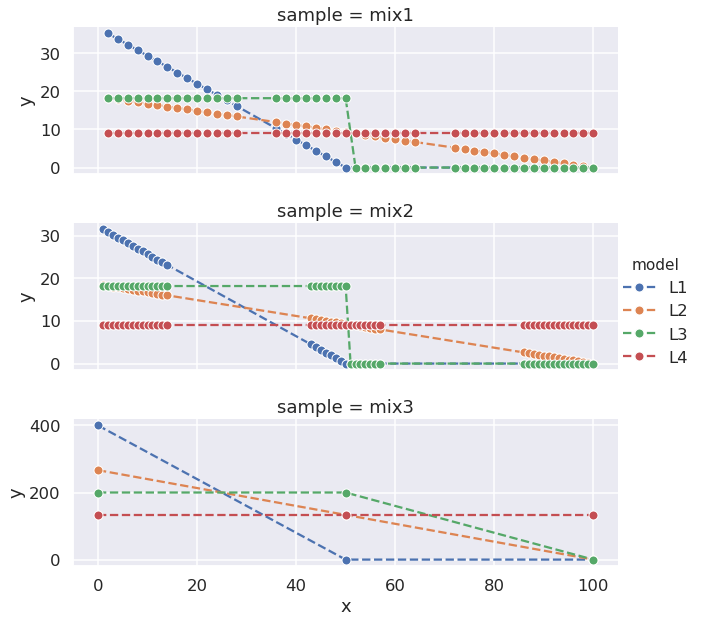

In [24]:
fg = m_nvar_aaf_plot(region='autosomes', vartype='snp', p_som2germ=4)
attila_utils.savefig(fg, 'vaf-mix123-L1234')

In [25]:
%connect_info

{
  "shell_port": 38713,
  "iopub_port": 38853,
  "stdin_port": 60005,
  "control_port": 46953,
  "hb_port": 44771,
  "ip": "127.0.0.1",
  "key": "eb4fefea-c17707f49256e2ad87631092",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-b75cbd35-f29d-4ee2-86ac-12e943769b92.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
